# Server Hack Prediction

## Table of Contents

1. [Problem Statement](#section1)<br>
2. [Importing Packages](#section2)<br>
3. [Loading Data](#section3)<br>
  - 3.1 [Description of the Datasets](#section301)<br>
  - 3.2 [Pandas Profiling before Data Preprocessing](#section302)<br>
4. [Data Preprocessing](#section4)<br>
  - 4.1 [Removing highly correlated columns](#section401)<br>
  - 4.2 [Removing columns with more than 50% zeroes](#section402)<br>
  - 4.3 [Filling missing values](#section403)<br>
  - 4.4 [Transforming date columns](#section404)<br>
  - 4.4 [Pandas Profiling after Data Preprocessing](#section404)<br>
  - 4.5 [Exploratory Data Analysis](#section405)<br>
5. [Data preparation for model building](#section5)<br>
  - 5.1 [Dummification / One-Hot Encoding](#section501)<br>
  - 5.2 [Merging all columns togethers](#section502)<br>
  - 5.3 [Segregating Train and Test data](#section503)<br>
  - 5.4 [Applying PCA for dimentionality reduction](#section504)<br>
  - 5.5 [Splitting Train data further in to train and validation data for model building](#section505)<br>
  - 5.6 [Applying SMOTING for imbalanced data](#section503)<br>
6. [Ensemble Modelling and Prediction](#section6)<br>
   - 6.1 [Linear Regression](#section601)
   - 6.2 [Random Forest](#section602) 
   - 6.3 [KNN](#section603)
   - 6.4 [Naive Bayes](#section604)
   - 6.5 [SVM](#section605) 
7.  [Conclusion](#section7)<br>
    

<a id=section1></a>
# 1. Problem Statement

**Predict if the server will be hacked.**

All the countries across the globe have adapted to means of digital payments. And with the increased volume of digital payments, hacking has become a pretty common event wherein the hacker can try to hack your details just with your phone number linked to your bank account. However, there is data with some anonymized variables based on which one can predict that the hack is going to happen. 

Your work is to build a predictive model which can identify a pattern in these variables and suggest that a hack is going to happen so that the cyber security can somehow stop it before it actually happens. You have to predict the column : "MALICIOUS_OFFENSE".

Hackathon link: https://www.hackerearth.com/challenges/hiring/novartis-data-science-hiring-challenge/

<a id=section2></a>
# 2. Importing Packages

In [28]:
import numpy as np                     

import pandas as pd

# To suppress pandas warnings.
pd.set_option('mode.chained_assignment', None) 

# To display all the data in each column
pd.set_option('display.max_colwidth', -1)         

pd.get_option("display.max_rows",10000)

# To display every column of the dataset in head()
pd.options.display.max_columns = 100               

import warnings
warnings.filterwarnings('ignore')     

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

# To apply seaborn styles to the plots.
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3, color_codes=True)      

<a id=section3></a>

# 3. Loading Data

In [30]:
# loading data from csv file to a data frame
df_train = pd.read_csv("Train.csv", index_col='INCIDENT_ID')
df_test = pd.read_csv("Test.csv", index_col='INCIDENT_ID')

# Adding new column 'isTestData' so that we can easily separate train and test 
# data during prediction process
df_train['IS_TEST_DATA'] = 0

df_test['IS_TEST_DATA'] = 1

# concat train and test data for data pre processing
df_hack = pd.concat([df_train,df_test])

# print train and test shape
df_train.shape, df_test.shape

((23856, 18), (15903, 17))

In [31]:
# delete train and test variables
del df_train
del df_test

<a id=section301></a>
## 3.1 Description of the Datasets

#### a. Check shape

In [32]:
df_hack.shape

(39759, 18)

#### b. info

**Input Variables:**


1.  INCIDENT_ID: Unique Identifier for an incident log.
2.  DATE: Date wof incident occurence.
3.  X_1-X_15: Anonymized logging parameters.

**Output Variables:**

1.  MULTIPLE_OFFENSE: Indicates if the incident was a hack.

In [33]:
df_hack.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39759 entries, CR_102659 to CR_33545
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DATE              39759 non-null  object 
 1   X_1               39759 non-null  int64  
 2   X_2               39759 non-null  int64  
 3   X_3               39759 non-null  int64  
 4   X_4               39759 non-null  int64  
 5   X_5               39759 non-null  int64  
 6   X_6               39759 non-null  int64  
 7   X_7               39759 non-null  int64  
 8   X_8               39759 non-null  int64  
 9   X_9               39759 non-null  int64  
 10  X_10              39759 non-null  int64  
 11  X_11              39759 non-null  int64  
 12  X_12              39450 non-null  float64
 13  X_13              39759 non-null  int64  
 14  X_14              39759 non-null  int64  
 15  X_15              39759 non-null  int64  
 16  MULTIPLE_OFFENSE  23856 non-null  

**Observations :**  

We have missing values for **X_12**.

#### c. describe

In [34]:
df_hack.describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE,IS_TEST_DATA
count,39759.000000,39759.000000,39759.000000,39759.000000,39759.000000,39759.000000,39759.000000,39759.000000,39759.000000,39759.000000,39759.000000,39450.000000,39759.000000,39759.000000,39759.000000,23856.000000,39759.000000
mean,0.477502,24.763777,24.612490,4.279735,2.452753,6.126462,4.870947,0.978168,4.917981,1.243366,206.954350,0.973333,85.218869,72.492014,33.447899,0.955231,0.399985
std,1.428755,15.235522,15.131877,2.956638,1.963184,4.463585,3.870959,1.460421,1.367462,1.017419,93.061957,1.060945,27.555325,43.353765,8.357811,0.206800,0.489901
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7.000000,8.000000,2.000000,1.000000,3.000000,2.000000,0.000000,5.000000,1.000000,174.000000,1.000000,72.000000,29.000000,34.000000,1.000000,0.000000
50%,0.000000,24.000000,24.000000,4.000000,3.000000,5.000000,4.000000,1.000000,5.000000,1.000000,249.000000,1.000000,98.000000,62.000000,34.000000,1.000000,0.000000
75%,0.000000,36.000000,35.000000,6.000000,5.000000,8.000000,7.000000,1.000000,6.000000,1.000000,249.000000,1.000000,103.000000,107.000000,34.000000,1.000000,1.000000
max,7.000000,52.000000,52.000000,10.000000,5.000000,19.000000,18.000000,99.000000,6.000000,90.000000,332.000000,90.000000,117.000000,142.000000,50.000000,1.000000,1.000000


**Observations :** Looks like there are some outliers. Let's confirm same from pandas profiling in next step.


 <a id=section302></a>
## 3.2 Pandas Profiling before Data Preprocessing

In [35]:
# To install pandas profiling please run this command.

#!pip install folium==0.2.1
#!pip install pandas-profiling --upgrade

In [36]:
from pandas_profiling import ProfileReport

# Running pandas profiling to get better understanding of data
# profile =  ProfileReport(df_hack, title='Pandas Profiling Report before data preprocessing', html={'style':{'full_width':True}})
# profile.to_file(output_file="report_before_processing.html")

 <a id=section4></a>
# 4. Data Preprocessing

 <a id=section401></a>
 
## 4.1 Removing highly correlated columns

**NOTE:**

From pandas profiling we can observe **X_2 and X_3**  has high correlation. Let's delete **X_3**

In [37]:
df_hack.drop('X_3', axis = 1, inplace=True)

 <a id=section402></a>
 
## 4.2 Removing columns with more than 50% zeroes

**NOTE:**

From pandas profiling we can observe **X_1** has 80% of zeroes. Let's delete **X_1**

In [38]:
df_hack.drop('X_1', axis=1,inplace=True)

 <a id=section403></a>
 
## 4.3 Transforming date columns

### a. Converting DATE to pandas datetime.

In [39]:
df_hack['DATE'] = pd.to_datetime(df_hack['DATE'] , errors = 'coerce', utc = True)
df_hack.dtypes

DATE                datetime64[ns, UTC]
X_2                 int64              
X_4                 int64              
X_5                 int64              
X_6                 int64              
X_7                 int64              
X_8                 int64              
X_9                 int64              
X_10                int64              
X_11                int64              
X_12                float64            
X_13                int64              
X_14                int64              
X_15                int64              
MULTIPLE_OFFENSE    float64            
IS_TEST_DATA        int64              
dtype: object

In [40]:
df_hack.dtypes

DATE                datetime64[ns, UTC]
X_2                 int64              
X_4                 int64              
X_5                 int64              
X_6                 int64              
X_7                 int64              
X_8                 int64              
X_9                 int64              
X_10                int64              
X_11                int64              
X_12                float64            
X_13                int64              
X_14                int64              
X_15                int64              
MULTIPLE_OFFENSE    float64            
IS_TEST_DATA        int64              
dtype: object

### b. Feature extraction from DATE column

In [41]:
df_hack['YEAR'] = df_hack['DATE'].dt.year

df_hack['MONTH'] = df_hack['DATE'].dt.month

df_hack['DAY'] = df_hack['DATE'].dt.day

In [42]:
# Weekend or Weekday
df_hack['dayofweek_name'] = df_hack['DATE'].dt.dayofweek
df_hack['IS_WEEKEND'] = np.where(df_hack['dayofweek_name'].isin([5,6]),1,0)

In [43]:
# quarter of an year
df_hack['QUARTER_OF_YEAR'] = df_hack['DATE'].dt.quarter

In [44]:
# drop DATE, dayofweek_name columns
df_hack.drop(['DATE', 'dayofweek_name'], axis=1, inplace=True)

 <a id=section404></a>
 
## 4.4 Filling missing values

In [45]:
df_hack.isnull().sum()

X_2                 0    
X_4                 0    
X_5                 0    
X_6                 0    
X_7                 0    
X_8                 0    
X_9                 0    
X_10                0    
X_11                0    
X_12                309  
X_13                0    
X_14                0    
X_15                0    
MULTIPLE_OFFENSE    15903
IS_TEST_DATA        0    
YEAR                0    
MONTH               0    
DAY                 0    
IS_WEEKEND          0    
QUARTER_OF_YEAR     0    
dtype: int64

**NOTE:**

From above we can observe **X_12** has missing values. As column name is not given and it looks like numerical , first we have to figureout whether **X_12** is numerical or categorical column. Let's check how many unique values column has.

In [46]:
df_hack.nunique()

X_2                 52 
X_4                 10 
X_5                 5  
X_6                 19 
X_7                 19 
X_8                 27 
X_9                 7  
X_10                26 
X_11                150
X_12                24 
X_13                68 
X_14                69 
X_15                36 
MULTIPLE_OFFENSE    2  
IS_TEST_DATA        2  
YEAR                28 
MONTH               12 
DAY                 31 
IS_WEEKEND          2  
QUARTER_OF_YEAR     4  
dtype: int64

**NOTE :**

1. As there are only 24 unique values, we can safely assume X_12 as categorical column. Let's fill it with mode.

2. Columns X_1 to X_12 looks like numerical but after printing unique values in each of them they look more like categorical.

In [47]:
 # Replacing the missing values with mode.
df_hack['X_12'].fillna(df_hack['X_12'].mode()[0], inplace=True)

In [48]:
df_hack.isnull().sum()

X_2                 0    
X_4                 0    
X_5                 0    
X_6                 0    
X_7                 0    
X_8                 0    
X_9                 0    
X_10                0    
X_11                0    
X_12                0    
X_13                0    
X_14                0    
X_15                0    
MULTIPLE_OFFENSE    15903
IS_TEST_DATA        0    
YEAR                0    
MONTH               0    
DAY                 0    
IS_WEEKEND          0    
QUARTER_OF_YEAR     0    
dtype: int64

 <a id=section405></a>
## 4.5 Pandas Profiling after Data Preprocessing

In [49]:
# Running pandas profiling to get better understanding of data
# profile =  ProfileReport(df_hack, title='Pandas Profiling Report after data preprocessing', html={'style':{'full_width':True}})
# profile.to_file(output_file="report_after_processing.html")

 <a id=section406></a>
## 4.6 Exploratory Data Analysis

**NOTE:**

As Univeriate analysis is already done using pandas-profiling, let's do multivariate analysis here.

In [50]:
df_hack.columns

Index(['X_2', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'X_10', 'X_11', 'X_12',
       'X_13', 'X_14', 'X_15', 'MULTIPLE_OFFENSE', 'IS_TEST_DATA', 'YEAR',
       'MONTH', 'DAY', 'IS_WEEKEND', 'QUARTER_OF_YEAR'],
      dtype='object')

### How is hacking behaviour over years?

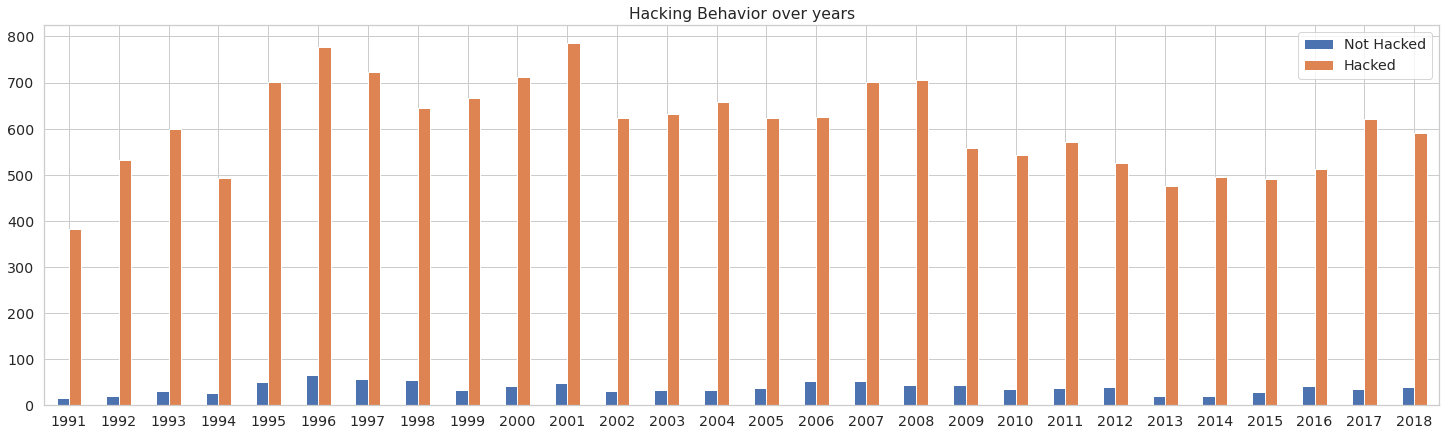

In [51]:
df = pd.DataFrame(
	{
	'Not Hacked': df_hack[df_hack['MULTIPLE_OFFENSE'] == 0.0]['YEAR'].value_counts(sort=False),
  'Hacked': df_hack[df_hack['MULTIPLE_OFFENSE'] != 1.0]['YEAR'].value_counts(sort=False)
	}
	) 
df.plot.bar(rot=0,figsize=(25, 7), title='Hacking Behavior over years')

### How is hacking behaviour spread across months of an year?



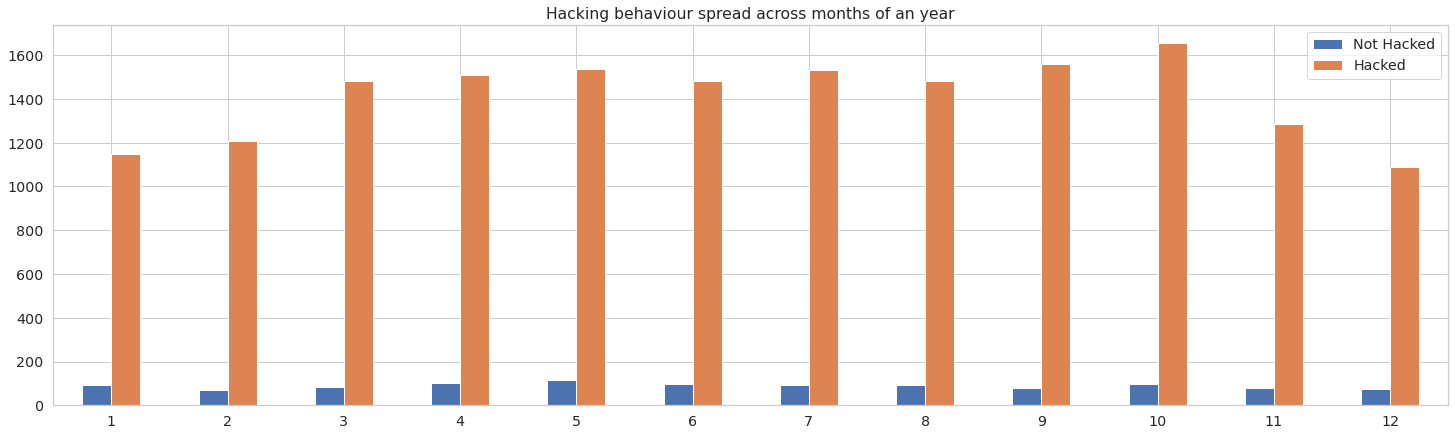

In [52]:
df = pd.DataFrame(
	{
	'Not Hacked': df_hack[df_hack['MULTIPLE_OFFENSE'] == 0.0]['MONTH'].value_counts(sort=False),
  'Hacked': df_hack[df_hack['MULTIPLE_OFFENSE'] != 1.0]['MONTH'].value_counts(sort=False)
	}
	) 
df.plot.bar(rot=0,figsize=(25, 7), title = 'Hacking behaviour spread across months of an year')

### How is hacking behaviour spread across days of month?

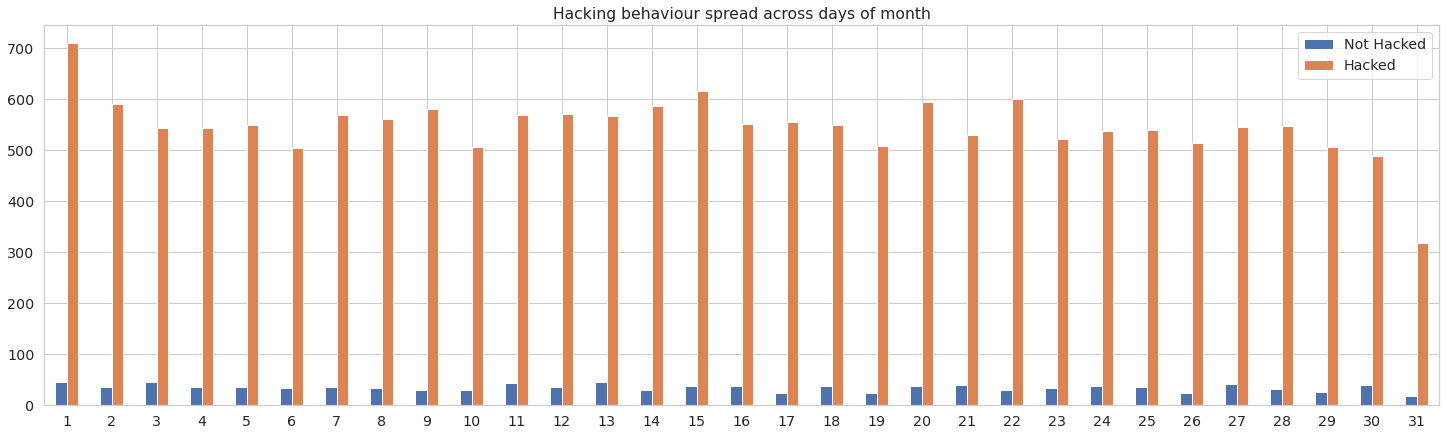

In [53]:
df = pd.DataFrame(
	{
	'Not Hacked': df_hack[df_hack['MULTIPLE_OFFENSE'] == 0.0]['DAY'].value_counts(sort=False),
  'Hacked': df_hack[df_hack['MULTIPLE_OFFENSE'] != 1.0]['DAY'].value_counts(sort=False)
	}
	)
df.plot.bar(rot=0,figsize=(25, 7), title='Hacking behaviour spread across days of month')

### Weekday vs Weekend

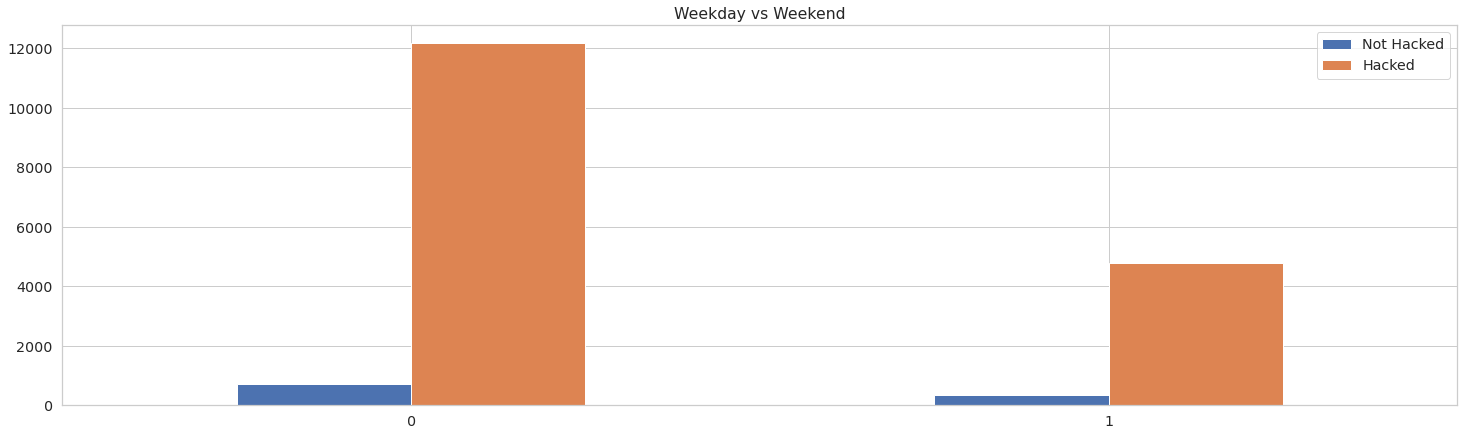

In [54]:
df = pd.DataFrame(
	{
	'Not Hacked': df_hack[df_hack['MULTIPLE_OFFENSE'] == 0.0]['IS_WEEKEND'].value_counts(sort=False),
  'Hacked': df_hack[df_hack['MULTIPLE_OFFENSE'] != 1.0]['IS_WEEKEND'].value_counts(sort=False)
	}
	) 
df.plot.bar(rot=0,figsize=(25, 7), title = 'Weekday vs Weekend')



```
`# This is formatted as code`
```

### Hack VS Quarter of an year

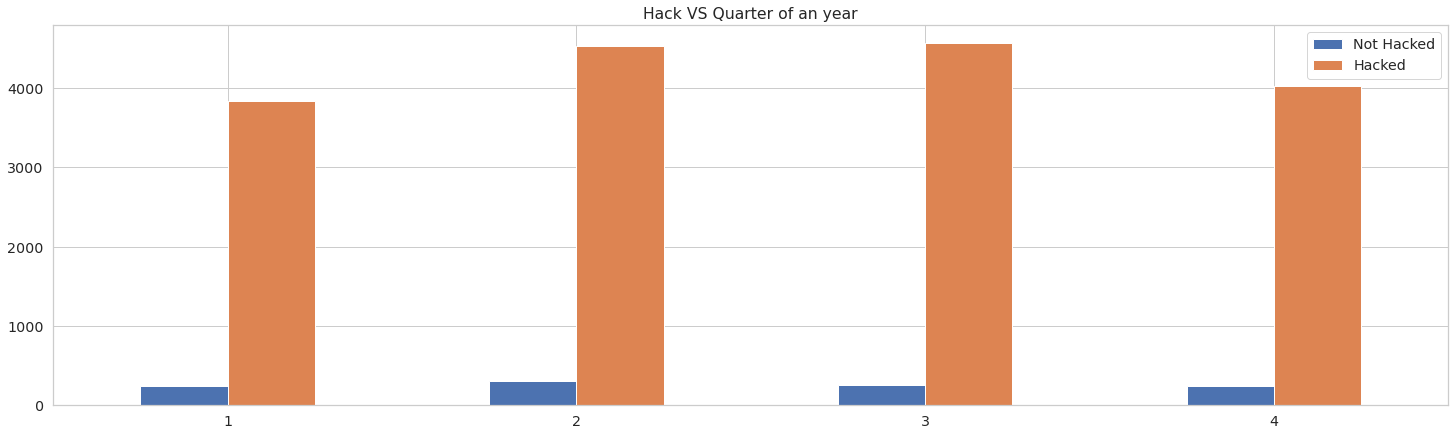

In [55]:
df = pd.DataFrame(
	{
	'Not Hacked': df_hack[df_hack['MULTIPLE_OFFENSE'] == 0.0]['QUARTER_OF_YEAR'].value_counts(sort=False),
  'Hacked': df_hack[df_hack['MULTIPLE_OFFENSE'] != 1.0]['QUARTER_OF_YEAR'].value_counts(sort=False)
	}
	) 
df.plot.bar(rot=0,figsize=(25, 7), title = 'Hack VS Quarter of an year')

 <a id=section5></a>
# 5. Data preparation for model building

In [ ]:
df_hack.columns

Index(['X_2', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'X_10', 'X_11', 'X_12',
       'X_13', 'X_14', 'X_15', 'MULTIPLE_OFFENSE', 'IS_TEST_DATA', 'YEAR',
       'MONTH', 'DAY', 'IS_WEEKEND', 'QUARTER_OF_YEAR'],
      dtype='object')

In [ ]:
feature_cols = list(df_hack.columns)
feature_cols.remove('IS_TEST_DATA')
feature_cols.remove('MULTIPLE_OFFENSE')
feature_cols

['X_2',
 'X_4',
 'X_5',
 'X_6',
 'X_7',
 'X_8',
 'X_9',
 'X_10',
 'X_11',
 'X_12',
 'X_13',
 'X_14',
 'X_15',
 'YEAR',
 'MONTH',
 'DAY',
 'IS_WEEKEND',
 'QUARTER_OF_YEAR']

**NOTE:**

Columns X_1 to X_12 looks like numerical but after printing unique values in each of them they look more like categorical. Let's change their datatype to string to make them completely categorical.

In [ ]:
for col in feature_cols:
  df_hack[col] = df_hack[col].astype(str)

df_hack.dtypes

X_2                 object 
X_4                 object 
X_5                 object 
X_6                 object 
X_7                 object 
X_8                 object 
X_9                 object 
X_10                object 
X_11                object 
X_12                object 
X_13                object 
X_14                object 
X_15                object 
MULTIPLE_OFFENSE    float64
IS_TEST_DATA        int64  
YEAR                object 
MONTH               object 
DAY                 object 
IS_WEEKEND          object 
QUARTER_OF_YEAR     object 
dtype: object

 <a id=section501></a>
## 5.1 Dummification / One-Hot Encoding of categorical variables

In [ ]:
df_hack_cat = pd.get_dummies(data=df_hack[feature_cols],drop_first=True)
len(df_hack_cat.columns)

571

**Observations:**

We have 571 categorical columns after one-hot encoding. As all columns are one-hot encoded, we need not do standardisation.

<a id=section502></a>
## 5.2 Merging all columns together

In [ ]:
df_hack_sd = pd.concat([df_hack_cat, df_hack['IS_TEST_DATA'],df_hack[ 'MULTIPLE_OFFENSE']],axis=1).reindex(df_hack.index)
df_hack_sd.shape

(39759, 573)

 <a id=section503></a>
 ## 5.3 Segregating Train and Test data

In [ ]:
df_hack_train = df_hack_sd[df_hack_sd['IS_TEST_DATA'] == 0]
df_hack_test = df_hack_sd[df_hack_sd['IS_TEST_DATA'] == 1]

In [ ]:
# dropping Is_Test_Data column
df_hack_train.drop('IS_TEST_DATA', axis=1, inplace=True)
df_hack_test.drop('IS_TEST_DATA', axis=1, inplace=True)

In [ ]:
# drop MULTIPLE_OFFENSE column in test data
df_hack_test.drop(['MULTIPLE_OFFENSE'], axis=1, inplace=True)

df_hack_train.shape,df_hack_test.shape

((23856, 572), (15903, 571))

 <a id=section504></a>
## 5.4 Applying PCA for dimentionality reduction

In [ ]:
feature_cols = list(df_hack_train.columns)
feature_cols.remove('MULTIPLE_OFFENSE')
len(feature_cols)

571

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(0.95).fit(df_hack_train[feature_cols])

In [ ]:
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
plt.ylabel('% Variance Explained')
plt.xlabel('Number of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')
plt.plot(var)

In [ ]:
print('%d components explain 95%% of the variation in data' % pca.n_components_)

135 components explain 95% of the variation in data


**NOTE:**

I think we are good with 95% variance explianed. Let's apply PCA on train and test data

In [ ]:
pca_hack = PCA(n_components=135)
principal_components_hack_train = pca_hack.fit_transform(df_hack_train[feature_cols])
principal_components_hack_test = pca_hack.fit_transform(df_hack_test[feature_cols])

In [ ]:
principal_components_hack_train = pd.DataFrame(data = principal_components_hack_train)
principal_components_hack_test = pd.DataFrame(data = principal_components_hack_test)
principal_components_hack_test.index = df_hack_test.index
principal_components_hack_train.shape, principal_components_hack_test.shape

((23856, 135), (15903, 135))

 <a id=section505></a>
 ## 5.5 Splitting Train data further in to train and validation data for model building

In [ ]:
 X = principal_components_hack_train
 y = df_hack_train['MULTIPLE_OFFENSE']

 X.shape, y.shape

((23856, 135), (23856,))

 <a id=section506></a>
## 5.6 Applying SMOTING for imbalanced data

In [ ]:
# Check distribution of target variable
y.value_counts() 

1.0    22788
0.0    1068 
Name: MULTIPLE_OFFENSE, dtype: int64

**NOTE:**

We can clearly observe there is class imbalance in target variable. Let's apply **SMOTING**

In [ ]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X_sm, y_sm = sm.fit_sample(X, y.ravel())

X = pd.DataFrame(X_sm,columns = X.columns)
y = pd.Series(y_sm)

In [ ]:
# Check distribution of target variable
y.value_counts()

1.0    22788
0.0    22788
dtype: int64

**NOTE:** Now target variable is balanced

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.3)

In [ ]:
print('Train cases as below')
print('X_train shape: ',X_train.shape)
print('y_train shape: ',y_train.shape)
print('\nTest cases as below')
print('X_test shape: ',X_test.shape)
print('y_test shape: ',y_test.shape)

Train cases as below
X_train shape:  (31903, 135)
y_train shape:  (31903,)

Test cases as below
X_test shape:  (13673, 135)
y_test shape:  (13673,)


 <a id=section6></a>
 # 6. Ensemble Modelling and Prediction
 
 Ensemble modeling is a process where multiple diverse models are created to predict an outcome, either by using many different modeling algorithms or using different training data sets. The ensemble model then aggregates the prediction of each base model and results in once final prediction for the unseen data.


 <a id=section601></a>
 ## 6.1 Logistic Regression
 
 
Logistic regression is the appropriate regression analysis to conduct when the dependent variable is dichotomous (binary).  Like all regression analyses, the logistic regression is a predictive analysis.  Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables.

Sometimes logistic regressions are difficult to interpret; the Intellectus Statistics tool easily allows you to conduct the analysis, then in plain English interprets the output.

Logistic Regression was used in the biological sciences in early twentieth century. It was then used in many social science applications. Logistic Regression is used when the dependent variable(target) is categorical.

For example,
1. To predict whether an email is spam (1) or (0)
1. Whether the tumor is malignant (1) or not (0)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

logistic = LogisticRegression(class_weight='balanced')
logistic.fit(X_train, y_train)

logistic_train_preds = logistic.predict(X_train)
logistic_test_preds = logistic.predict(X_test)

print(confusion_matrix(y_train, logistic_train_preds))
print(confusion_matrix(y_test, logistic_test_preds))

print(classification_report(y_train, logistic_train_preds))
print(classification_report(y_test, logistic_test_preds))

[[15537   415]
 [  704 15247]]
[[6681  155]
 [ 303 6534]]
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     15952
         1.0       0.97      0.96      0.96     15951

    accuracy                           0.96     31903
   macro avg       0.97      0.96      0.96     31903
weighted avg       0.97      0.96      0.96     31903

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      6836
         1.0       0.98      0.96      0.97      6837

    accuracy                           0.97     13673
   macro avg       0.97      0.97      0.97     13673
weighted avg       0.97      0.97      0.97     13673



 <a id=section602></a>
 ## 6.2 Random Forest

In [ ]:
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

rf_rs = RandomForestClassifier(max_samples=0.5) 
param_grid = {'n_estimators' : [25,50,75,100],
              'max_features' : [5,7,9,11,13],
             'min_samples_split': np.arange(0.001,0.1,0.001),
             'max_depth':np.arange(5,15,1)}

rf_rs = RandomizedSearchCV(estimator=rf_rs, param_distributions=param_grid,n_iter=100, n_jobs=-1)
rf_rs.fit(X_train, y_train)
  
print(rf_rs.best_estimator_)
print('Train Accuracy =',rf_rs.best_score_)

In [ ]:
rf_rs_train_preds = rf_rs.predict(X_train)
rf_rs_test_preds = rf_rs.predict(X_test)

print(confusion_matrix(y_train, rf_rs_train_preds))
print(confusion_matrix(y_test, rf_rs_test_preds))

print(classification_report(y_train, rf_rs_train_preds))
print(classification_report(y_test, rf_rs_test_preds))

[[15889    62]
 [  176 15776]]
[[6787   50]
 [ 153 6683]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     15951
         1.0       1.00      0.99      0.99     15952

    accuracy                           0.99     31903
   macro avg       0.99      0.99      0.99     31903
weighted avg       0.99      0.99      0.99     31903

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      6837
         1.0       0.99      0.98      0.99      6836

    accuracy                           0.99     13673
   macro avg       0.99      0.99      0.99     13673
weighted avg       0.99      0.99      0.99     13673



 <a id=section603></a>
## 6.3 KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score,accuracy_score,f1_score

train_performance={}
test_performance={}
 
for k in range(1,25,2):
    knn_temp=KNeighborsClassifier(n_neighbors=k,weights='distance')
    knn_temp.fit(X_train,y_train)
    k_train_preds=knn_temp.predict(X_train)
    k_test_preds=knn_temp.predict(X_test)
    train_performance[k]=recall_score(y_train,k_train_preds, average='weighted')
    test_performance[k]=recall_score(y_test,k_test_preds, average='weighted')

In [ ]:
keys = test_performance.keys()
train_values = train_performance.values()
test_values = test_performance.values()

In [ ]:
perf=pd.DataFrame()
perf['k']= keys
perf['train_performance']= train_values
perf['test_performance']= test_values

In [ ]:
perf.sort_values(by='test_performance', ascending=False, axis=0)

,k,train_performance,test_performance
3,7,1.0,0.957804
4,9,1.0,0.957524
2,5,1.0,0.957384
5,11,1.0,0.956965
6,13,1.0,0.956825
12,25,1.0,0.956686
7,15,1.0,0.956546
16,33,1.0,0.956546
14,29,1.0,0.956546
13,27,1.0,0.956406


In [ ]:
knn=KNeighborsClassifier(n_neighbors=7,weights='distance')
knn.fit(X_train,y_train)

knn_train_preds = knn.predict(X_train)
knn_test_preds = knn.predict(X_test)

print(confusion_matrix(y_train, knn_train_preds))
print(confusion_matrix(y_test, knn_test_preds))

print(classification_report(y_train, knn_train_preds))
print(classification_report(y_test, knn_test_preds))

[[15952     0]
 [    0 15951]]
[[6836    0]
 [1456 5381]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     15952
         1.0       1.00      1.00      1.00     15951

    accuracy                           1.00     31903
   macro avg       1.00      1.00      1.00     31903
weighted avg       1.00      1.00      1.00     31903

              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90      6836
         1.0       1.00      0.79      0.88      6837

    accuracy                           0.89     13673
   macro avg       0.91      0.89      0.89     13673
weighted avg       0.91      0.89      0.89     13673



 <a id=section604></a>
## 6.4 Naive Bayes 

In [ ]:
from sklearn.naive_bayes import GaussianNB
# Naive Bayes classification
gnb = GaussianNB(priors=None)

# Train classifier
gnb.fit(X_train,y_train)

gnb_train_preds = gnb.predict(X_train)
gnb_test_preds = gnb.predict(X_test)

print(confusion_matrix(y_train, gnb_train_preds))
print(confusion_matrix(y_test, gnb_test_preds))

print(classification_report(y_train, gnb_train_preds))
print(classification_report(y_test, gnb_test_preds))

[[13737  2215]
 [  657 15294]]
[[5919  917]
 [ 272 6565]]
              precision    recall  f1-score   support

         0.0       0.95      0.86      0.91     15952
         1.0       0.87      0.96      0.91     15951

    accuracy                           0.91     31903
   macro avg       0.91      0.91      0.91     31903
weighted avg       0.91      0.91      0.91     31903

              precision    recall  f1-score   support

         0.0       0.96      0.87      0.91      6836
         1.0       0.88      0.96      0.92      6837

    accuracy                           0.91     13673
   macro avg       0.92      0.91      0.91     13673
weighted avg       0.92      0.91      0.91     13673



bold text <a id=section605></a>
## 6.5 SVM

In [ ]:
# SVM
from sklearn import svm
model_svm = svm.SVC(probability=True, kernel='rbf', degree = 3)
model_svm.fit(X_train, y_train)

model_svm_train_preds = model_svm.predict(X_train)
model_svm_test_preds = model_svm.predict(X_test)

print(confusion_matrix(y_train, model_svm_train_preds))
print(confusion_matrix(y_test, model_svm_test_preds))

print(classification_report(y_train, model_svm_train_preds))
print(classification_report(y_test, model_svm_test_preds))

[[15952     0]
 [   41 15910]]
[[6835    1]
 [  82 6755]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     15952
         1.0       1.00      1.00      1.00     15951

    accuracy                           1.00     31903
   macro avg       1.00      1.00      1.00     31903
weighted avg       1.00      1.00      1.00     31903

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      6836
         1.0       1.00      0.99      0.99      6837

    accuracy                           0.99     13673
   macro avg       0.99      0.99      0.99     13673
weighted avg       0.99      0.99      0.99     13673



 <a id=section7></a>
 ## 7. Conclusion

**NOTE: **

From above models, it is clearly evident that **Random Forest has best Recall score** for both train and validation data. Let's use it for final model prediction.

In [ ]:
final_predictions = rf.predict(principal_components_hack_test)


df_hack_test = df_hack_test.reset_index();
final_preds = pd.DataFrame({});
final_preds['INCIDENT_ID'] = df_hack_test['INCIDENT_ID']
final_preds['MULTIPLE_OFFENSE'] =  final_predictions;
final_preds['MULTIPLE_OFFENSE'] = final_preds['MULTIPLE_OFFENSE'].astype(int);
final_preds = final_preds.set_index('INCIDENT_ID')
final_preds.to_csv("final_preds_rf.csv")